In [1]:
#데이터 전처리
import numpy as np
import pandas as pd
from datetime import datetime 

#데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns

#데이터 API Request
import requests

# 서론

안녕하세요. 저는 스트리미 데이터 엔지니어 포지션에 지원하는 박재성입니다. 

저는 전반적인 도메인 지식을 얻는것이, BTC-KRW데이터를 이해하는데 도움이 된다고 생각하여
먼저 주식가격과 거래량의 상관관계에 대해 조사해보았습니다. 

---
> **(흥국생명 투자자 가이드 중..)**
 우리는 주가가 상승하면 거래량이 늘어나는 경향이 있다고 알고 있습니다. 주가 상승을 기대하는 사자세력이 늘면서 거래를 증가시키고, 거래량 증가는 새로운 사자세력을 자극하며 추가상승을 부추기기 때문입니다. 반대로, .......
 <br>
 
>  **거래량과 주가와의 상관관계는 거래량이 증가추세면 주가는 상승합니다.** 그러다가 주가가 천장에 다가서면 주가상승에도 거래는 줄어드는 경향을 보입니다. **반대로 늘어나던 거래가 줄어들기 시작하면 주가하락을 예상해볼 수 있습니다.** 주가하락이 지속돼 바닥에 접근하면 거래는 증가하는 속성이 있습니다.

---

저는 이러한 경향, 즉 **거래량과 가격간의 양의 상관관계를 보이는지**,  **BTC-KRW 데이터**로 검증을 해보겠습니다.

---

# 1. 최근 5일간 BTC_KRW 가격과 거래량의 상관관계에 관하여

## API함수, Helper함수

In [37]:
API_HOST = 'https://api.gopax.co.kr'
START_DATE = '2020.11.14 00:00:00'
END_DATE = '2020.11.18 23:59:59'
INTERVAL = '1440' #1440minutes = 1day 


# GOPAX API를 사용하여 BTC-KRW데이터를 가져옵니다. 2차원 리스트를 반환합니다.
def request_BTCKRW_chart_data(API_HOST, start, end, interval):
    start_ms = str(round(datetime_to_milliseconds(start)))
    end_ms = str(round(datetime_to_milliseconds(end)))
    url = (API_HOST 
                           + '/trading-pairs/BTC-KRW/candles?start=' 
                           + start_ms
                           + '&end=' 
                           + end_ms
                           + '&interval=' 
                           +interval)
    print('Request data from...:',  url)
    print('START_DATE:', milliseconds_to_datetime(int(start_ms)))
    print('END_DATE:', milliseconds_to_datetime(int(end_ms)))


    return requests.get(url).json()


# Hepler Function : Datetime을 Milliseconds로 바꾸는 함수입니다.
def datetime_to_milliseconds(date):
    dt_obj = datetime.strptime(date,
                           '%Y.%m.%d %H:%M:%S')
    millisec = dt_obj.timestamp() * 1000
    return millisec

# Helper Function : Millseconds를 Datetime으로 바꾸는 함수입니다.
def milliseconds_to_datetime(ms):
    return datetime.fromtimestamp(ms/1000.0)

# 2차원 리스트 데이터를 Dataframe으로 바꾸고 Column명을 입력해줍니다.
def raw_data_to_dataframe(data):
    df = pd.DataFrame.from_records(data)                   #2차원 list를 dataframe 형식으로 변환
    df[0] = pd.to_datetime(df[0] , unit='ms')              #milliseconds 형태의 날짜 Column을 datetime 형태의 날짜로 변환
    df.columns = ['시작 기간','최저가','최고가','시가','종가','거래량'] #Column Name을 지정함
    
    return df

## API데이터 가져오기, 데이터 전처리

In [38]:
#Gopax API를 사용하여 BTC-KRW pairing 데이터를 가져옵니다.
data = request_BTCKRW_chart_data(API_HOST, START_DATE, END_DATE, INTERVAL)

Request data from...: https://api.gopax.co.kr/trading-pairs/BTC-KRW/candles?start=1605279600000&end=1605711599000&interval=1440
START_DATE: 2020-11-14 00:00:00
END_DATE: 2020-11-18 23:59:59


In [39]:
#2차원 리스트를 데이터 프레임으로 변환합니다.
df = raw_data_to_dataframe(data)
df

,시작 기간,최저가,최고가,시가,종가,거래량
0,2020-11-14,17476000,17993000,17983000,17800000,176.715177
1,2020-11-15,17551000,17820000,17802000,17687000,146.573468
2,2020-11-16,17561000,18451000,17664000,18272000,363.132873
3,2020-11-17,18195000,19409000,18273000,19336000,492.939612
4,2020-11-18,19000000,20303000,19345000,19711000,659.915773


## 데이터 시각화

**먼저 데이터의 전반적인 모습을 이해하기 위하여 종가와 거래량의 시계열 Plot을 그려봤습니다.**

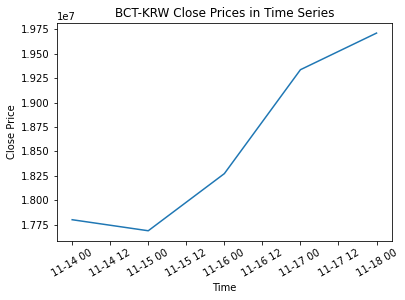

In [84]:
plt.plot(df['시작 기간'],df['종가'])
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('BCT-KRW Close Prices in Time Series')
plt.show()

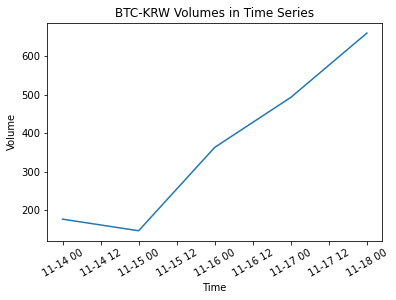

In [85]:
plt.plot(df['시작 기간'], df['거래량'])
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('Volume')
plt.title('BTC-KRW Volumes in Time Series')
plt.show()

## 상관관계분석, 산포도

**분포상으로 우리는 양의 상관관계를 가질것이라는 추론을 해볼 수 있습니다. 좀 더 명확히 상관관계를 알아보기 위해 산포도와 Pearson 상관관계분석을 진행하였습니다.**

Text(0, 0.5, 'Close')

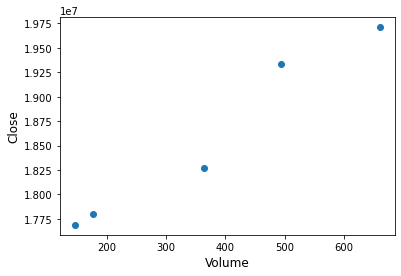

In [59]:
plt.scatter(df['거래량'], df['종가'])
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Close', fontsize=12)

In [71]:
df.corr(method='pearson')

,최저가,최고가,시가,종가,거래량
최저가,1.000000,0.968880,0.964530,0.930674,0.920776
최고가,0.968880,1.000000,0.896422,0.986646,0.984367
시가,0.964530,0.896422,1.000000,0.829390,0.819084
종가,0.930674,0.986646,0.829390,1.000000,0.978130
거래량,0.920776,0.984367,0.819084,0.978130,1.000000


In [72]:
print('종가와 거래량의 상관계수 :', '\033[1m' + str(df.corr(method='pearson').loc['종가', '거래량']))

종가와 거래량의 상관계수 : 0.9781298902364868


## 결론

산포도와 피어슨 상관계수를 확인했을 때, 산포도는 우상향의 그래프를 나타냈고, 상관계수는 0.98로 아주 강한 양의 상관관계를 나타냈습니다.
<br>
하지만, **저는 5일간의 데이터를 보고는 BTC-KRW의 가격과 거래량이 양의 상관관계를 가진다고 확신할 수 없었습니다.**
<br>
그래서 저는 한번 더, 1년간의 데이터를 분석을 시도해봤습니다.

# 2. 더 나아가서 : 1년간 BTC_KRW의 가격과 거래량의 상관관계에 대하여

## API데이터 가져오기, 전처리

In [101]:
START_DATE2='2019.11.17 00:00:00'
END_DATE2='2020.11.18 23:59:59'
data2 = request_BTCKRW_chart_data(API_HOST, START_DATE2, END_DATE2, INTERVAL)

Request data from...: https://api.gopax.co.kr/trading-pairs/BTC-KRW/candles?start=1573916400000&end=1605711599000&interval=1440
START_DATE: 2019-11-17 00:00:00
END_DATE: 2020-11-18 23:59:59


In [102]:
df2 = raw_data_to_dataframe(data2)
df2

,시작 기간,최저가,최고가,시가,종가,거래량
0,2019-11-17,9830000,10040000,9935000,9925000,117.836894
1,2019-11-18,9530000,9939000,9939000,9590000,187.602083
2,2019-11-19,9369000,9610000,9581000,9512000,235.796294
3,2019-11-20,9422000,9595000,9523000,9478000,159.362096
4,2019-11-21,8920000,9600000,9492000,9028000,293.843035
...,...,...,...,...,...,...
363,2020-11-14,17476000,17993000,17983000,17800000,176.715177
364,2020-11-15,17551000,17820000,17802000,17687000,146.573468
365,2020-11-16,17561000,18451000,17664000,18272000,363.132873
366,2020-11-17,18195000,19409000,18273000,19336000,492.939612


## 데이터 시각화 및 분석

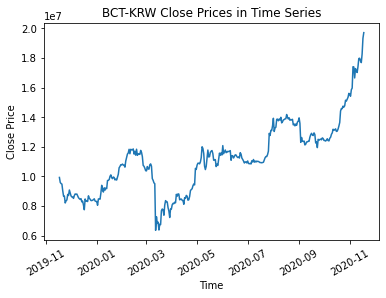

In [103]:
plt.plot(df2['시작 기간'],df2['종가'])
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('BCT-KRW Close Prices in Time Series')
plt.show()

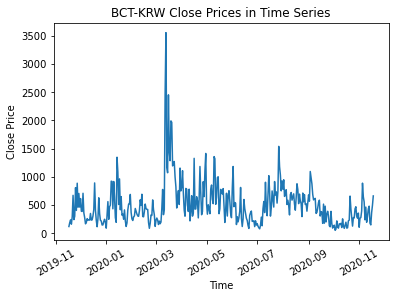

In [104]:
plt.plot(df2['시작 기간'],df2['거래량'])
plt.xticks(rotation=30)
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('BCT-KRW Close Prices in Time Series')
plt.show()

**가장 눈에뛰는점은 2020년 3월경에 가격이 폭락할때, 거래량은 급증하는것입니다. BTC-KRW의 1년간의 가격과 거래량의 상관관계는 제가 가정했던 양의 상관관계보다는, 음의 상관관계를 뛸 것으로 보입니다.**

## 산포도, 상관관계분석

Text(0, 0.5, 'Close')

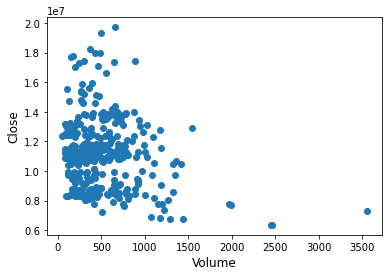

In [105]:
plt.scatter(df2['거래량'], df2['종가'])
plt.xlabel('Volume', fontsize=12)
plt.ylabel('Close', fontsize=12)

In [106]:
df2.corr(method='pearson')

,최저가,최고가,시가,종가,거래량
최저가,1.000000,0.990206,0.993575,0.995704,-0.274413
최고가,0.990206,1.000000,0.994577,0.994818,-0.173843
시가,0.993575,0.994577,1.000000,0.990129,-0.225981
종가,0.995704,0.994818,0.990129,1.000000,-0.220773
거래량,-0.274413,-0.173843,-0.225981,-0.220773,1.000000


In [107]:
print('종가와 거래량의 상관계수 :', '\033[1m' + str(df2.corr(method='pearson').loc['종가', '거래량']))

종가와 거래량의 상관계수 : -0.22077317246472666


## 결론

 5일간의 데이터와는 달리, 1년간의 데이터는 약한 음의 상관관계를 보였습니다. 특히, 2020년 3월, 4월에는 더 강한 음의 상관관계를 나타낼 것으로 보입니다. 또한 코로나19의 영향이 비트코인의 가격과 거래량에도 영향을 미친것으로 보입니다.
 
<br>

---

저의 가설인 BTC-KRW의 가격과 거래량간에는 양의 상관관계를 보인다는 것은 기각하는 것이 좋다고 보여집니다.

---

<br>

하지만, **저는 가격과 거래량의 양의 상관관계가, BTC-KRW와는 달리, 주식에는 적합한 가설일지도 모른다는 생각에 S&P500의 10년간의 데이터를 분석해봤습니다.**

# 3. 한번 더 나아가서 : 10년간 S&P500 종목들의 가격과 거래량의 상관관계에 대하여

## S&P500 데이터 스크래핑, Hepler Function 정의

In [ ]:
import yfinance as yf


#S&P500 종목 List를 Wikipedia에서 스크레핑합니다.
sp_assets = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

#S&P500의 데이터를 가져오고, 각 종목의 거래량과 가격의 상관계수를 Dictionary로 반환합니다.
def get_correlation_as_dictionary(stock_list, start, end, market='us'):
    corr_box = dict()
    for i in range(len(stock_list)):
        if market=='kor':
            data = yf.download(stock_list[i]+'.KS', start, end)
            corr_box[list(kospi_200.values())[i]] = data.corr().loc['Close', 'Volume']
        else:
            data = yf.download(stock_list[i], start, end)
            corr_box[snp_list[i]] = data.corr().loc['Close', 'Volume']
            
    return corr_box 

#Helper Function : 가장 강한 양의상관관계 Top10, 음의 상관관계 Top10를 출력하는 헬퍼 함수입니다.
def print_top10_corr(corr_dict, top=10, order='desc'):
    if order=='asc':
        t = sorted(corr_dict.items(), key=lambda x:x[1])[:top] 
    elif order=='desc':
        t = sorted(corr_dict.items(), key=lambda x:-x[1])[:top]
    
    for x in t:
        print(x[0], x[1])
        

## S&P500 가격과 거래량 데이터 가져오기, 종목-상관계수 Dictonary

In [8]:
snp_list = list(sp_assets[0]['Symbol'])
snp_corr = get_correlation_as_dictionary(snp_list, '2010-11-17', '2020-11-18')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 데이터 분석 및 시각화

In [14]:
print_top10_corr(snp_corr, top=20)

AMD 0.4189928019265173
TSLA 0.3946057727585245
BIO 0.38285233133954455
ARE 0.274816325004856
CBOE 0.20635642596667303
CNC 0.18383900274394546
CHTR 0.1688295193571211
ATO 0.1574644574142017
ANET 0.14907246708135116
LNT 0.11747686873714404
ABMD 0.11371414013456388
CDW 0.11282165518741252
BDX 0.10632917145104459
CTLT 0.10629552354708899
ALB 0.10247552855374568
AJG 0.09543934306460616
AMZN 0.08759033473330641
AVGO 0.07162412834287459
ALGN 0.0703055684887429
CLX 0.06658613229911732


**먼저 강한 양의 상관계수를 가진 주식 종목 20개를 출력해보았습니다. AMD, TESLA, Bio-Rad Laboratories, Inc. 정도를 제외하고는 그렇다한 상관관계를 보이지 않았습니다. 그래서 강한 음의 상관계수 20개를 출력해보았습니다.**

In [15]:
print_top10_corr(snp_corr, top=20, order='asc')

OXY -0.6722600775540117
ALL -0.6052479040602546
BAC -0.594779812718635
GLW -0.5835952620743848
GOOG -0.5398845895802828
AMP -0.5393888424569603
GOOGL -0.530333909063499
AFL -0.4954692865112946
A -0.47331462887601905
AIZ -0.4664480700685261
AAPL -0.45567476554956576
APA -0.4541433834444078
AMGN -0.43704074508680724
ABT -0.4340090348611237
AXP -0.4237130786684497
AON -0.40288308287231483
BAX -0.3994798127033611
BK -0.3974451265692136
ADM -0.3944115083156183
ANTM -0.3939492880686284


**강한 음의 상관관계를 가진 TOP20개만 봤을 때, 대부분의 종목들이 중간 혹은 약한 음의 상관관계를 가졌습니다. 저는 S&P500의 상관계수를 히스토그램으로 나타내서 전반적인 모습을 확인해봤습니다.**

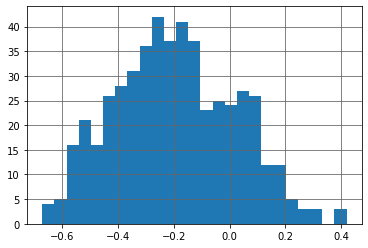

In [11]:
plt.hist(snp_corr.values(), bins=25)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

## 결론

**저는 히스토그램을 통하여 S&P500의 종목들은 대부분 -0.2이하로 음의 상관관계를 뛴다는것을 확인할 수 있었습니다. 다시한번 저의 첫 가정 '가격과 거래량은 양의 상관관계를 뛴다'는 가정은 맞지 않다는 것으로 판단할 수 있었습니다.**

# 4. 또 한번 더 나아가서 : 10년간 KOSPI200 가격과 거래량의 상관관계에 대하여

## 데이터 스크래핑

In [20]:
from bs4 import BeautifulSoup
import re

base_url = 'http://finance.naver.com/sise/entryJongmok.nhn?&page='

#네이버 증권에서 KOSPI200 주식 종목을 스크래핑하는 함수.
def scrape_kospi_200_from_naver():
    kospi_200 = dict()
    for i in range(1, 22, 1):
        url = base_url + str(i)
        r = requests.get(url)
        soup = BeautifulSoup(r.text,'lxml')
        items = soup.find_all('td', {'class':'ctg'})


        for item in items:
            txt = item.a.get('href')
            k = re.search('[\d]+',txt)
            if k:
                code=k.group()
                name = item.text
                kospi_200[code] = name

    return kospi_200


In [21]:
kospi_200 = scrape_kospi_200_from_naver()

In [22]:
kospi_corr = get_correlation_as_dictionary(list(kospi_200.keys()), '2010-11-17', '2020-11-18', 'kor')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 데이터 분석 및 시각화

In [23]:
print_top10_corr(kospi_corr, top=20)

SK바이오팜 0.5643971988693622
GS 0.49013065045191767
포스코케미칼 0.4883761356165111
남해화학 0.4770641000795546
카카오 0.44948356756174546
롯데정밀화학 0.4362272719778461
녹십자 0.4338425485543271
F&F 0.4283002707655423
한일현대시멘트 0.41509002525762884
일양약품 0.40146485927150316
동아에스티 0.39386144568644615
메리츠증권 0.379127225145652
삼양홀딩스 0.375698989377801
부광약품 0.3737813561058276
삼성전기 0.3616432068543456
한화솔루션 0.3588907759732189
SKC 0.3571496884633326
휠라홀딩스 0.34152728578891056
DB하이텍 0.3308893669833002
LG화학 0.3196572158223169


In [25]:
print_top10_corr(kospi_corr, top=20, order='asc')

한국테크놀로지그룹 -0.5038433760119345
이마트 -0.4715803767129456
삼성엔지니어링 -0.4116006074364599
고려아연 -0.3809928724718621
HDC현대산업개발 -0.36151052312191095
BNK금융지주 -0.33754650995229263
한화생명 -0.3220240343565778
SK하이닉스 -0.31653224178447836
효성 -0.29008016054494434
팬오션 -0.28554750010382307
강원랜드 -0.2848808184523253
롯데칠성 -0.2757426115313346
HMM -0.2600071698857478
에스원 -0.2504562063181859
신한지주 -0.24822225424161312
유한양행 -0.24083840167501255
엔씨소프트 -0.23773788132895232
한국전력 -0.22770037664342688
POSCO -0.21856807224955355
삼성화재 -0.21671537695639484


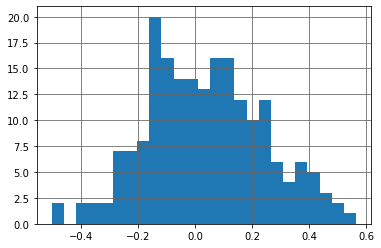

In [110]:
plt.hist(kospi_corr.values(), bins=25)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.show()

## 결론

S&P500과는 달리, KOSPI200의 가격과 거래량은 매우 약한 상관관계(-0.2 < p < 0.2)를 뛰고 있었습니다. 저는 가격과 거래량의 상관관계에 대한 통념은 모든 시장에 적용되는 것이 아니라, 시장마다 다르게 나타날 수 있다는 것을 확인할 수 있었습니다.

# 5. 최종 결론

저는 총 3개의 데이터 셋(BTC-KRW, S&P500, KOSPI200)을 통해 다음과 같은 결론을 얻을 수 있었습니다.

> '가격과 거래량은 양의 상관관계를 뛴다.'라는 통념은 우리가 알던것과 다르게 실제 시장에서는 그렇게 행동하지 않았다. 

> 장기간 동안 시장의 가격과 거래량은 이렇다한 상관관계를 보이지 않는다. 하지만 **BTC-KRW** 의 경우처럼 단기간에서의 폭락장 오히려 강한 음의 상관관계를 보일 수 있다.

> **'S&P500'** 은 다소 음의 상관관계를 뛰는 종목들이 많이 포진해있다.

> **'KOSPI200'** 은 그렇다한 상관관계를 보이지 않았다.

# 6. 프로젝트를 마치며

이번 스트리미 테스트를 하면서, 3개의 시장을 분석할 때마다 새로운 인사이트를 얻을 수 있어서 정말 좋은 경험이였습니다! 데이터를 통해서, 우리가 알고 있던 통념이 틀릴수 있다는 것을 증명할 때 저는 매우 기뻤습니다. 앞으로도, 좋은 인사이트를 창출할 수 있는 분석가가 되기 위해서 증진하겠습니다. 감사합니다!